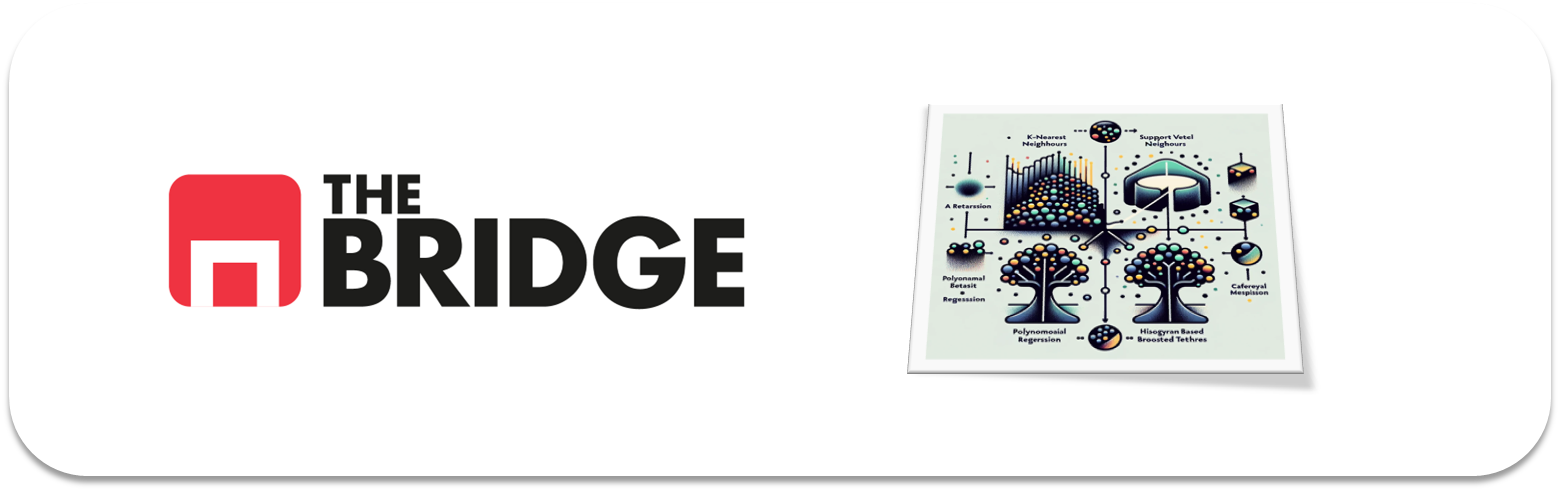

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [176]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import bootcampviztools as bviz

### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [125]:
df = pd.read_csv("./data/credit_npo.csv")
df.head(5)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

Descripcion textual de las variables

SeriousDlqin2yrs - La persona ha cometido un incumplimiento de pago en los ultimos 2 años.  
RevolvingUtilizationOfUnsecuredLines  - tasa de lineas de credito no aseguradas usadas (credito usado / total limite de credito)  
Age - Edad de la persona  
NumberOfTime30-59DaysPastDueNotWorse - Cantidad de veces que una persona ha tenido pagos atrasados de 30-59 días, pero no peor.  
DebtRatio - Nivel de dueda en porcentaje (relación deuda-ingreso).  
MonthlyIncome - Ingresos mensuales.  
NumberOfOpenCreditLinesAndLoans - Cantidad de prestamos y lineas de credito que tiene abierta la persona.  
NumberOfTimes90DaysLate - La cantidad de veces que una persona ha tenido pagos atrasados de 90 días o más.  
NumberRealEstateLoansOrLines - Cantidad de prestamos inmobiliarios  
NumberOfTime60-89DaysPastDueNotWorse -  La cantidad de veces que una persona ha tenido pagos atrasados de 60-89 días, pero no peor
NumberOfDependents - Cantidad de personas que dependen de esta persona.

clasificación inicial de sus variables en categóricas y numéricas.

In [127]:
def card_tipo(df,umbral_categoria = 8, umbral_continua = 30):
    # Primera parte: Preparo el dataset con cardinalidades, % variación cardinalidad, y tipos
    df_temp = pd.DataFrame([df.nunique(), df.nunique()/len(df) * 100, df.dtypes]) # Cardinaliad y porcentaje de variación de cardinalidad
    df_temp = df_temp.T # Como nos da los valores de las columnas en columnas, y quiero que estas sean filas, la traspongo
    df_temp = df_temp.rename(columns = {0: "Card", 1: "%_Card", 2: "Tipo"}) # Cambio el nombre de la transposición anterior para que tengan más sentido, y uso asignación en vez de inplace = True (esto es arbitrario para el tamaño de este dataset)

    # Corrección para cuando solo tengo un valor
    df_temp.loc[df_temp.Card == 1, "%_Card"] = 0.00

    # Creo la columna de sugerenica de tipo de variable, empiezo considerando todas categóricas pero podría haber empezado por cualquiera, siempre que adapte los filtros siguientes de forma correspondiente
    df_temp["tipo_sugerido"] = "Categorica"
    df_temp.loc[df_temp["Card"] == 2, "tipo_sugerido"] = "Binaria"
    df_temp.loc[df_temp["Card"] >= umbral_categoria, "tipo_sugerido"] = "Numerica discreta"
    df_temp.loc[df_temp["%_Card"] >= umbral_continua, "tipo_sugerido"] = "Numerica continua"
    # Ojo los filtros aplicados cumplen con el enunciado pero no siguen su orden y planteamiento

    return df_temp


In [128]:
card_tipo(df)

,Card,%_Card,Tipo,tipo_sugerido
SeriousDlqin2yrs,2,0.015953,int64,Binaria
RevolvingUtilizationOfUnsecuredLines,10764,85.857861,float64,Numerica continua
age,78,0.622158,int64,Numerica discreta
NumberOfTime30-59DaysPastDueNotWorse,10,0.079764,int64,Numerica discreta
DebtRatio,11547,92.103374,float64,Numerica continua
MonthlyIncome,4167,33.237617,float64,Numerica continua
NumberOfOpenCreditLinesAndLoans,43,0.342985,int64,Numerica discreta
NumberOfTimes90DaysLate,13,0.103693,int64,Numerica discreta
NumberRealEstateLoansOrLines,16,0.127622,int64,Numerica discreta
NumberOfTime60-89DaysPastDueNotWorse,8,0.063811,int64,Numerica discreta


### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

Estamos frente a un problema de clasificacion. Tenemos que indicar con negativo o positivo (clase 0 o clase 1) si la persona ha incumplido seriamente con el pago en los ultimos dos años. 
Es un problema supervisado porque tenemos identificada la variable objetivo que queremos predecir.  
La variable objetivo es SeriousDlqin2yrs.

In [129]:
target = "SeriousDlqin2yrs"

### #1.3
Pinta la distribución de frecuencias del target y coméntala

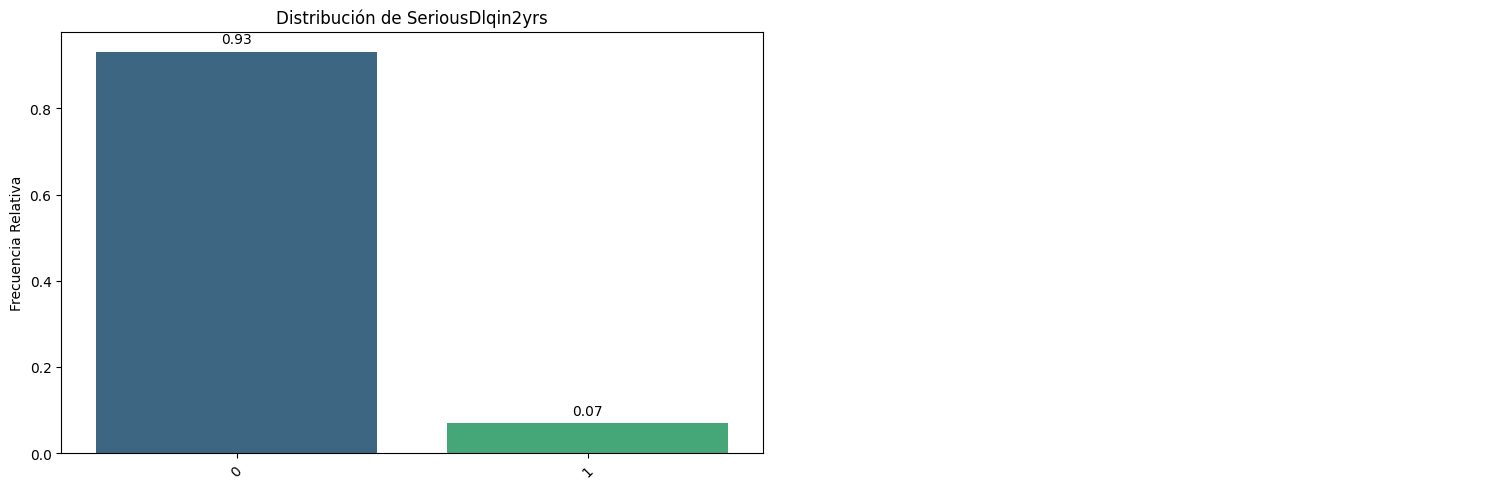

In [130]:
bviz.pinta_distribucion_categoricas(df,[target],True,True)

Vemos que la distribucion está extremadamente desbalanceada.  
Esto casi seguro impactará la prediccion de la clase 1, al tener una proporcion de muestras tan baja.  
Para mejorar el desempeño de los modelos para esa clase probablente tengamos que hacer un ajuste para balancear las clases.

### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

Renombramos las columnas para facilitar el proceso.

In [131]:
df = df.rename(columns={"SeriousDlqin2yrs": "Dlqin",
"RevolvingUtilizationOfUnsecuredLines": "Revolving",
"age": "age",
"NumberOfTime30-59DaysPastDueNotWorse": "Due30-59",
"DebtRatio": "DebtRatio",
"MonthlyIncome": "MonthlyIncome",
"NumberOfOpenCreditLinesAndLoans": "CreditLines",
"NumberOfTimes90DaysLate": "Due90",
"NumberRealEstateLoansOrLines": "RealEstateLoans",
"NumberOfTime60-89DaysPastDueNotWorse": "Due60-89",
"NumberOfDependents": "Dependents"})

In [132]:
target = "Dlqin"

Observamos los nulos

Vemos que tiene una larga cola. Asi que graficamos su boxplot para ver los outliers

<Axes: ylabel='MonthlyIncome'>

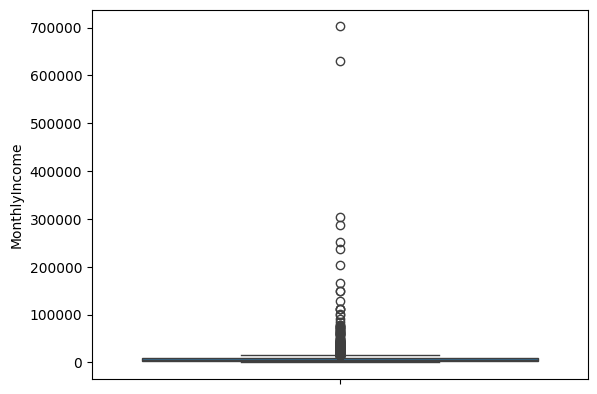

In [135]:
sns.boxplot(df["MonthlyIncome"])

Como vemos hay dos outliers que se salen mucho de la agrupación y afectan la distribucion. Los podemos eliminar.

In [136]:
df["MonthlyIncome"].nlargest(2)

3291    702500.0
5733    629000.0
Name: MonthlyIncome, dtype: float64

In [137]:
df.iloc[df["MonthlyIncome"].nlargest(2).index]

,Dlqin,Revolving,age,Due30-59,DebtRatio,MonthlyIncome,CreditLines,Due90,RealEstateLoans,Due60-89,Dependents
3291,0,0.071628,50,0,0.008268,702500.0,12,0,4,0,2.0
5733,0,0.000000,83,0,0.000000,629000.0,3,0,0,0,0.0


In [138]:
df = df.drop(df["MonthlyIncome"].nlargest(2).index)

<Axes: >

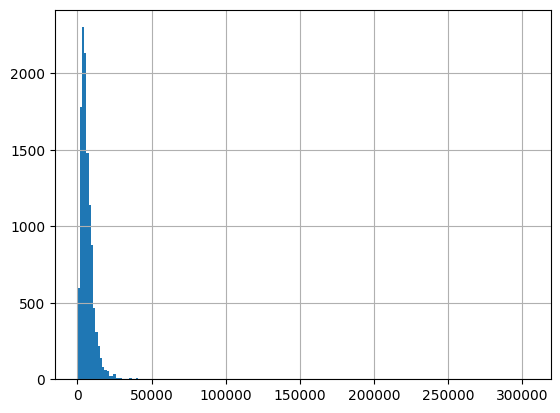

In [139]:
df["MonthlyIncome"].hist(bins=200)

<Axes: ylabel='MonthlyIncome'>

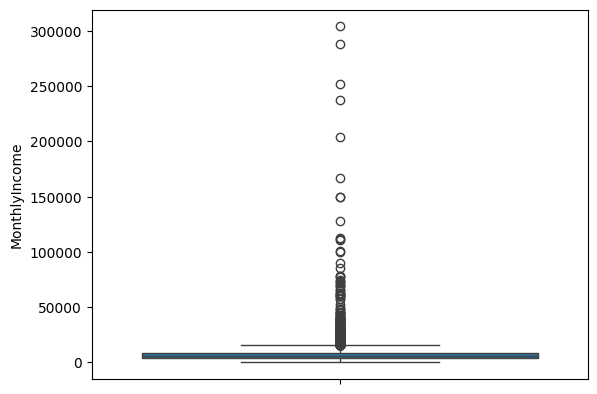

In [140]:
sns.boxplot(df["MonthlyIncome"])

Ahora está un poco mejor

Ahora vemos Dependents

### Seleccionamos variables numericas y categoricasm (primera seleccion)

In [189]:
features_num = df.columns.to_list()
features_num.remove(target)
features_num

['Revolving',
 'age',
 'Due30-59',
 'DebtRatio',
 'MonthlyIncome',
 'CreditLines',
 'Due90',
 'RealEstateLoans',
 'Due60-89',
 'Dependents']

### Divido en train y test

In [143]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df,test_size=0.2,random_state=42)

### Trato los nulos

In [144]:
# Observamos los nulos
for col in df.columns:
    print(f"{col}: {df[col].isna().sum()} ({round(df[col].isna().sum()/len(df),2)})")

Dlqin: 0 (0.0)
Revolving: 0 (0.0)
age: 0 (0.0)
Due30-59: 0 (0.0)
DebtRatio: 0 (0.0)
MonthlyIncome: 721 (0.06)
CreditLines: 0 (0.0)
Due90: 0 (0.0)
RealEstateLoans: 0 (0.0)
Due60-89: 0 (0.0)
Dependents: 177 (0.01)


Relleno los nulos de MonthlyIncome con la media

In [148]:
train_set.loc[train_set["MonthlyIncome"].isna(), "MonthlyIncome"] = train_set["MonthlyIncome"].mean()

In [203]:
test_set.loc[test_set["MonthlyIncome"].isna(), "MonthlyIncome"] = test_set["MonthlyIncome"].mean()

Relleno los nulos de Dependents con la moda

In [158]:
train_set.loc[train_set["Dependents"].isna(), "Dependents"] = train_set["Dependents"].mode()[0]

In [204]:
test_set.loc[test_set["Dependents"].isna(), "Dependents"] = test_set["Dependents"].mode()[0]

### Hago un mini-EDA

In [159]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10028 entries, 7494 to 7272
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Dlqin            10028 non-null  int64  
 1   Revolving        10028 non-null  float64
 2   age              10028 non-null  int64  
 3   Due30-59         10028 non-null  int64  
 4   DebtRatio        10028 non-null  float64
 5   MonthlyIncome    10028 non-null  float64
 6   CreditLines      10028 non-null  int64  
 7   Due90            10028 non-null  int64  
 8   RealEstateLoans  10028 non-null  int64  
 9   Due60-89         10028 non-null  int64  
 10  Dependents       10028 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 940.1 KB


Analisis bivariante del target con las posibles features

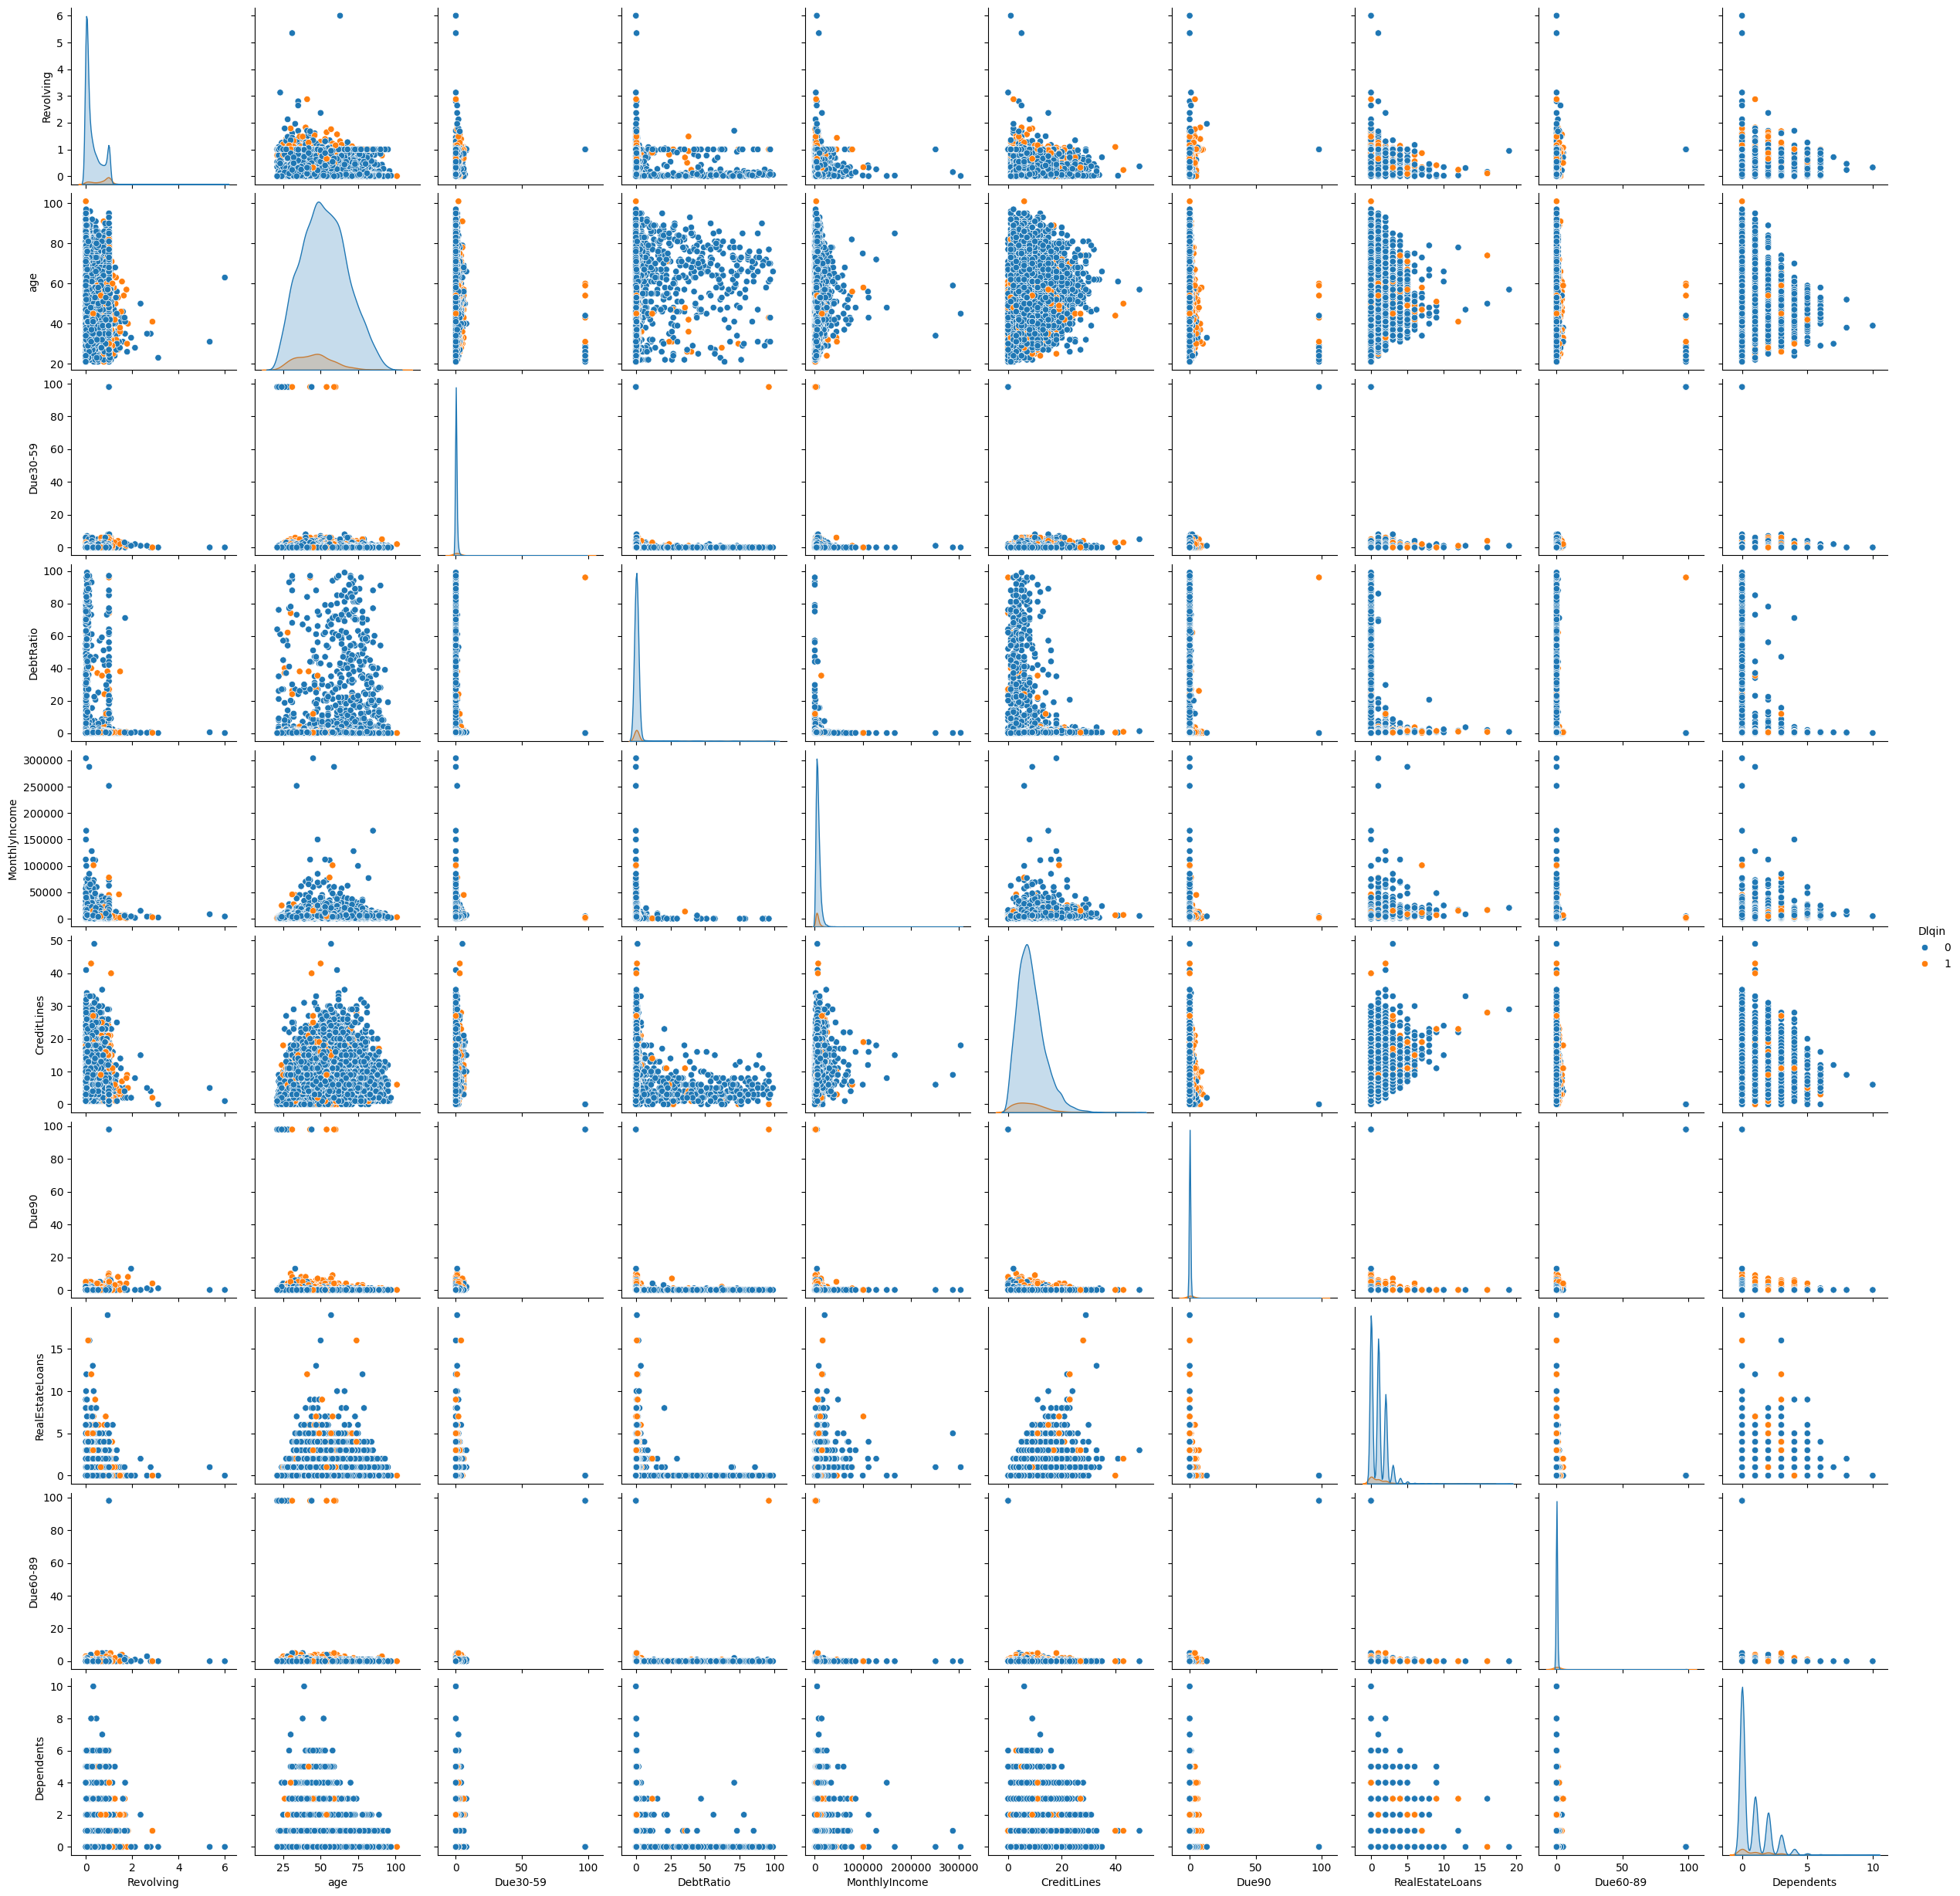

In [86]:
sns.pairplot(train_set, hue = target)

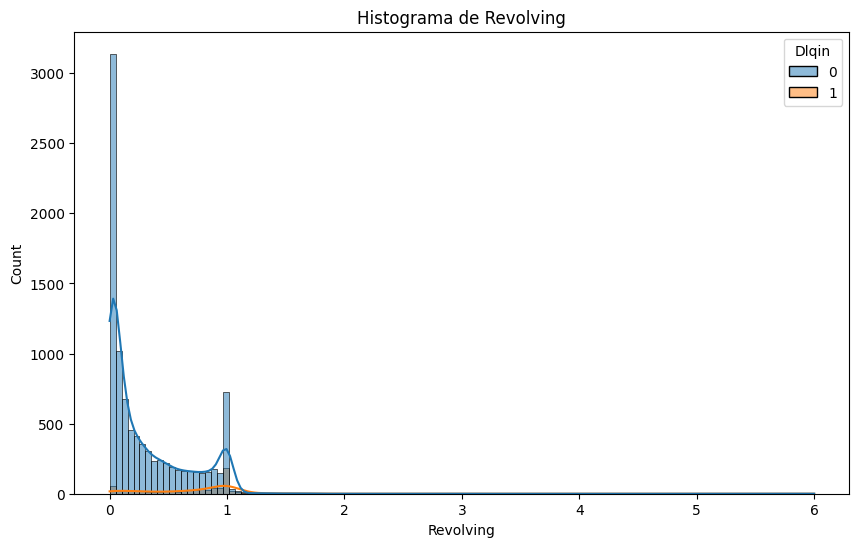

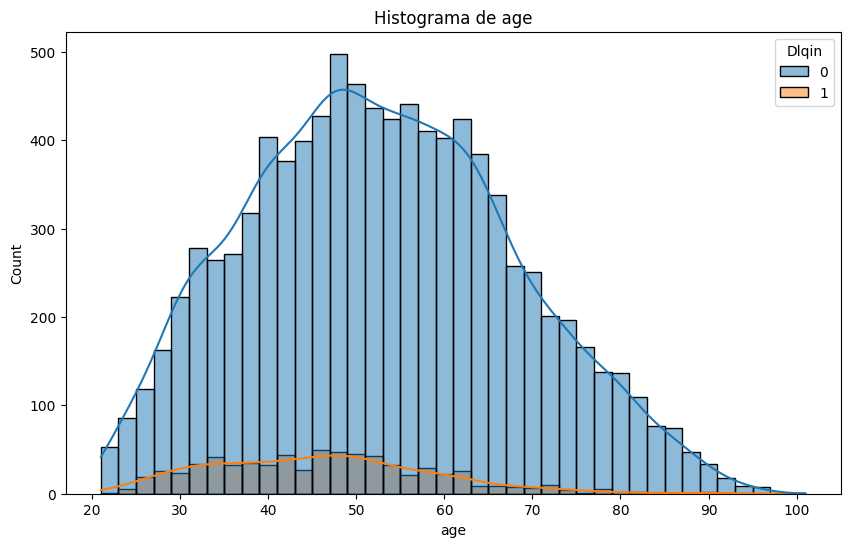

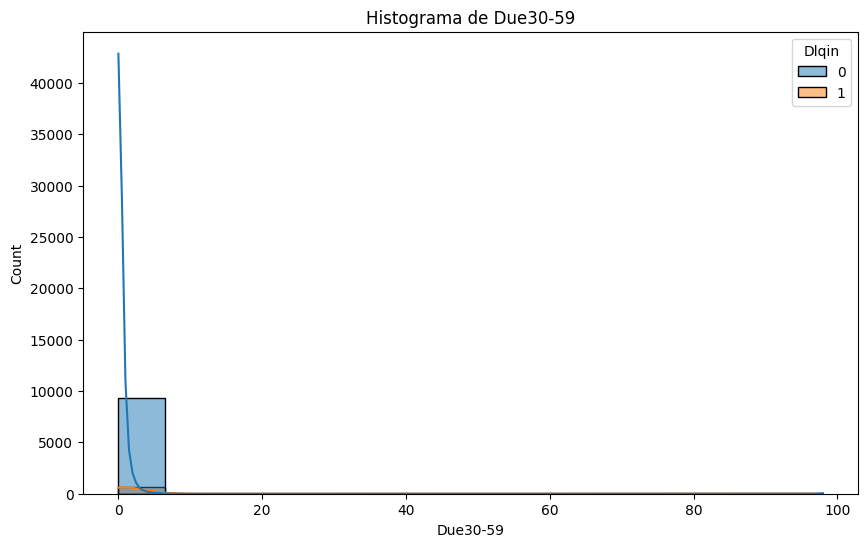

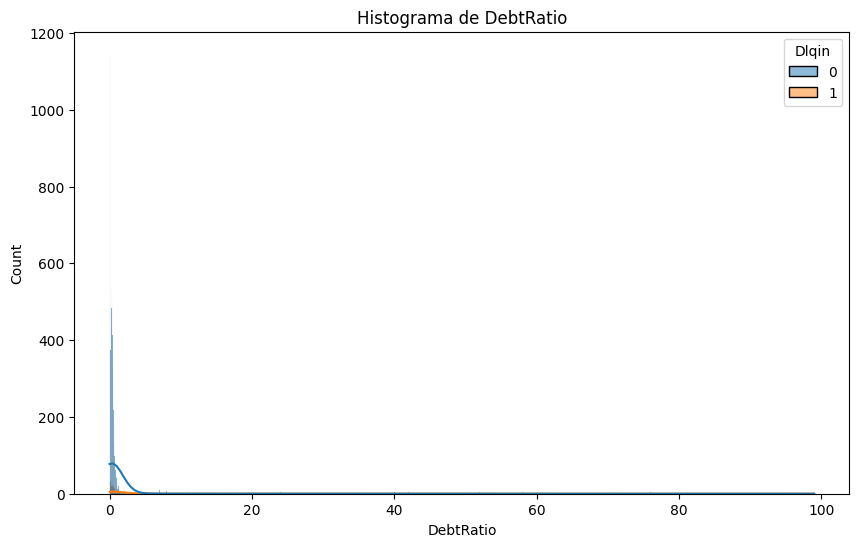

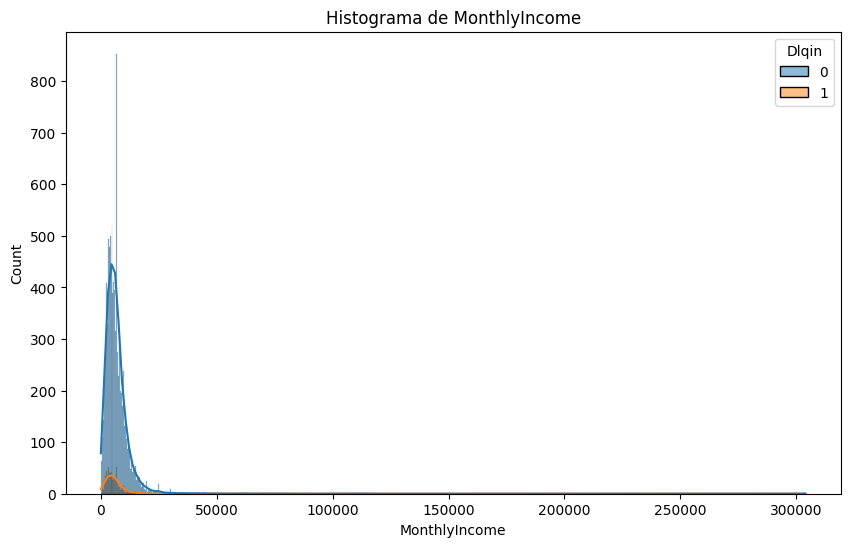

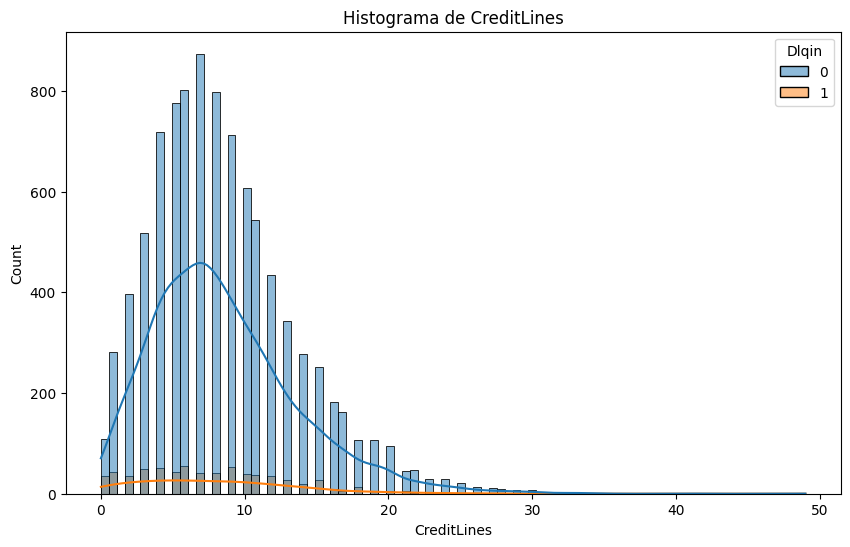

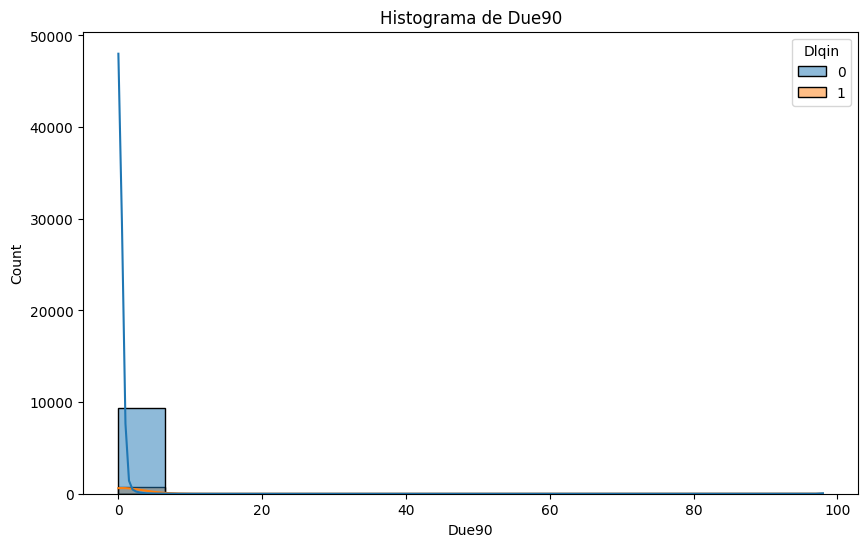

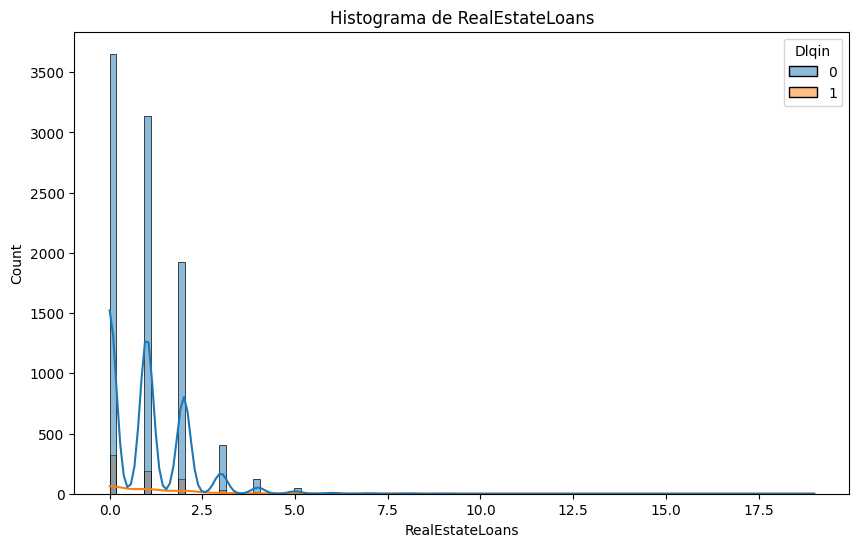

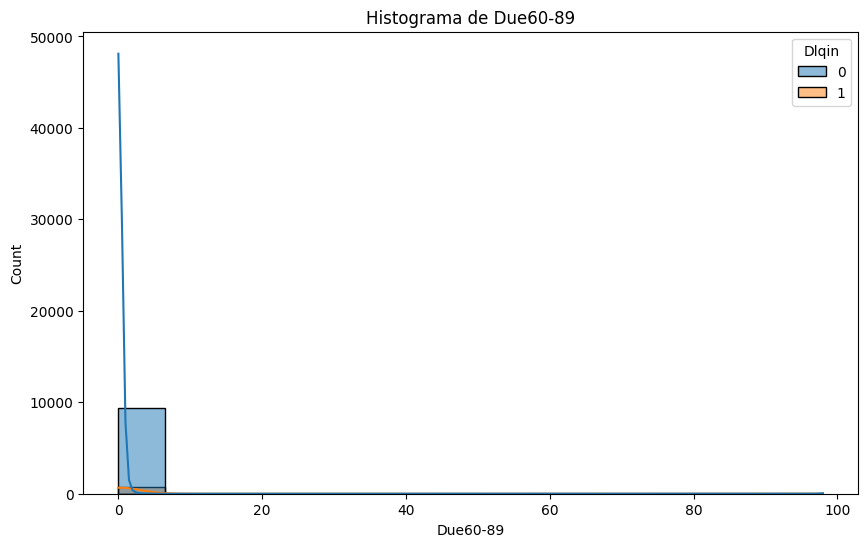

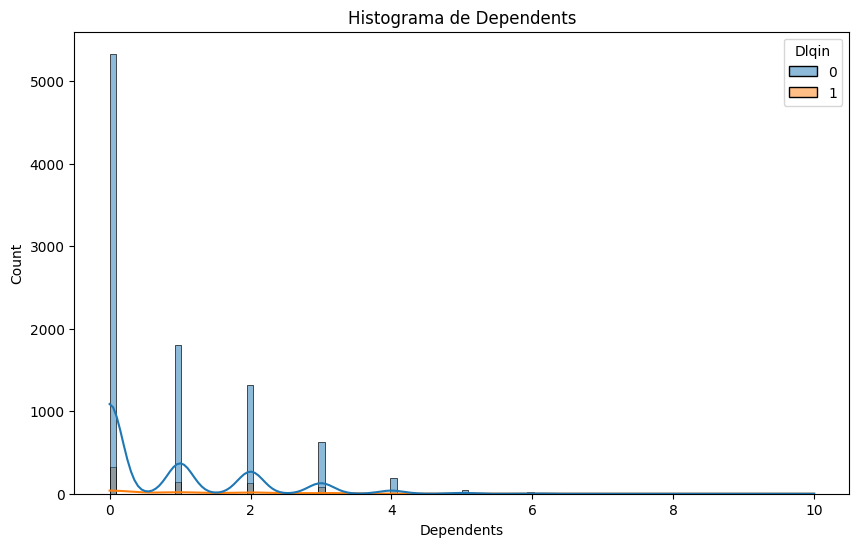

In [178]:
for col in features_num:
    plt.figure(figsize=(10, 6))
    sns.histplot(train_set,x = col,hue=target, kde=True)
    plt.title(f'Histograma de {col}')
    plt.show()  

Aunque se observa que alguna variable discrimina mas que otra. Sin embargo me quedo con todas. Ya mas adelante puedeo descartar segun indique el modelo.

Lista de potenciales features

In [179]:
features_num

['Revolving',
 'age',
 'Due30-59',
 'DebtRatio',
 'MonthlyIncome',
 'CreditLines',
 'Due90',
 'RealEstateLoans',
 'Due60-89',
 'Dependents']

Procesamos las numericas

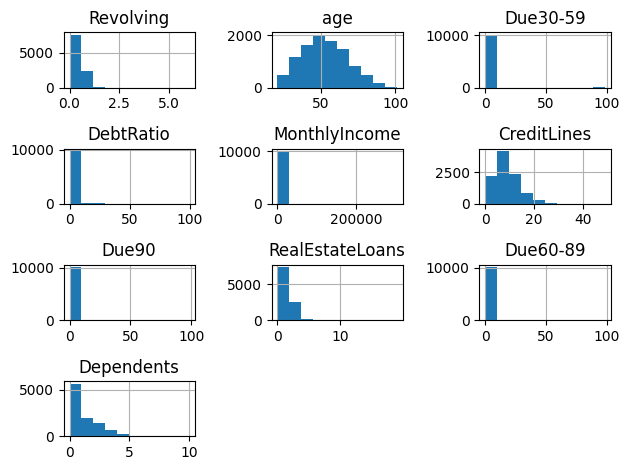

In [180]:
train_set[features_num].hist()
plt.tight_layout()

In [181]:
train_bck = train_set.copy() # Copia de seguridad antes de transformar

In [205]:
test_bck = test_set.copy() # Copia de seguridad antes de transformar

In [194]:
features_transform = features_num.copy()
features_transform.remove("age")
features_transform.remove("CreditLines")
features_transform.remove("Dependents")
features_transform

['Revolving',
 'Due30-59',
 'DebtRatio',
 'MonthlyIncome',
 'Due90',
 'RealEstateLoans',
 'Due60-89']

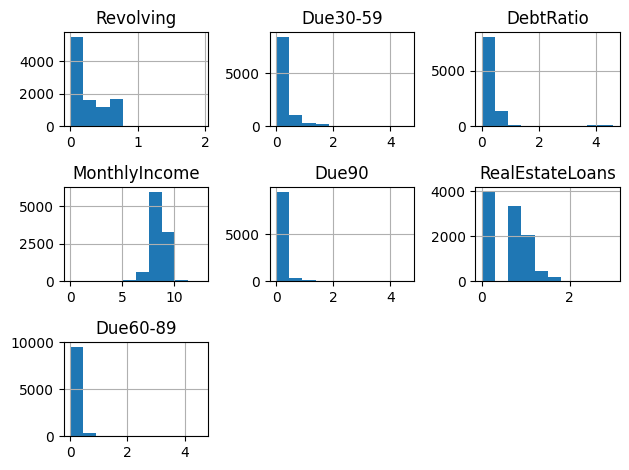

In [ ]:
for feature in features_transform:
    train_set[feature] = (train_set[feature]+1).apply(np.log) # Desplazo la variable sumando 1 para evitar el log 0.

train_set[features_transform].hist()
plt.tight_layout();

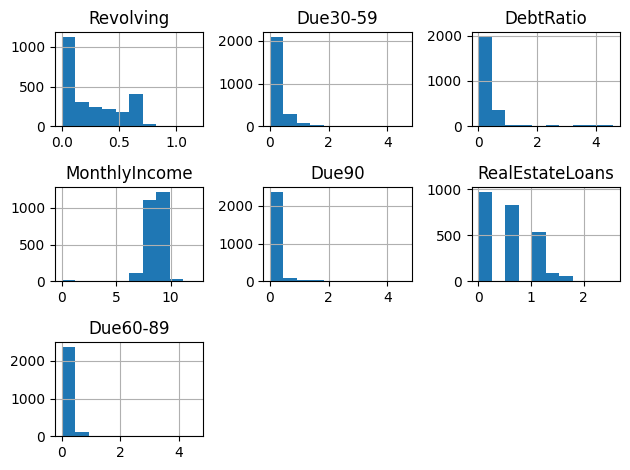

In [206]:
for feature in features_transform:
    test_set[feature] = (test_set[feature]+1).apply(np.log) # Desplazo la variable sumando 1 para evitar el log 0.

test_set[features_transform].hist()
plt.tight_layout();

Escalamos las numéricas

In [198]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_set[features_num]) # Entreno solo con datos de train

StandardScaler()

In [199]:
# Aplico escalado a ambos sets, train y test
train_set[features_num] = scaler.transform(train_set[features_num])

In [207]:
test_set[features_num] = scaler.transform(test_set[features_num])

In [200]:
train_set[features_num].describe() # Ahora la desviación estándar (std) de todas las numéricas de train es 1

,Revolving,age,Due30-59,DebtRatio,MonthlyIncome,CreditLines,Due90,RealEstateLoans,Due60-89,Dependents
count,1.002800e+04,1.002800e+04,1.002800e+04,1.002800e+04,1.002800e+04,1.002800e+04,1.002800e+04,1.002800e+04,1.002800e+04,1.002800e+04
mean,3.365654e-17,-1.523401e-16,9.211264e-17,-9.618685e-17,7.581579e-16,4.109641e-17,-4.959911e-18,-7.723291e-17,-3.259370e-17,-7.510723e-17
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-9.983085e-01,-2.074715e+00,-3.820003e-01,-6.112246e-01,-9.972921e+00,-1.655365e+00,-1.997294e-01,-1.103022e+00,-1.809279e-01,-7.173914e-01
25%,-8.786094e-01,-7.440693e-01,-3.820003e-01,-4.110771e-01,-4.381907e-01,-6.832971e-01,-1.997294e-01,-1.103022e+00,-1.809279e-01,-7.173914e-01
50%,-3.992484e-01,-7.874666e-02,-3.820003e-01,-2.152143e-01,1.155605e-01,-1.000566e-01,-1.997294e-01,2.688610e-01,-1.809279e-01,-7.173914e-01
75%,8.193592e-01,7.196405e-01,-3.820003e-01,4.585711e-03,5.194597e-01,4.831838e-01,-1.997294e-01,1.071361e+00,-1.809279e-01,1.653081e-01
max,6.744304e+00,3.247867e+00,1.147286e+01,6.328203e+00,4.756319e+00,7.870896e+00,1.545302e+01,4.826156e+00,1.775422e+01,8.109604e+00


In [201]:
features_all = features_num  # Estas son las variables que vamos a usar en nuestro modelo
features_all

['Revolving',
 'age',
 'Due30-59',
 'DebtRatio',
 'MonthlyIncome',
 'CreditLines',
 'Due90',
 'RealEstateLoans',
 'Due60-89',
 'Dependents']

Separamos en features (X) y target (y)

In [209]:
X_train = train_set[features_all]
y_train = train_set[target]

In [208]:
X_test = test_set[features_all]
y_test = test_set[target]

### Modelos

In [210]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

model_names = ["KNN","Random Forest","CatBoost"]

knn = KNeighborsClassifier(n_neighbors = 5)
rf_clf = RandomForestClassifier(random_state= 42)
cat_clf = CatBoostClassifier(random_state= 42, verbose = False)

model_set = [knn, rf_clf, cat_clf]

In [211]:
from sklearn.model_selection import cross_val_score

metricas_cv = {}
valores = []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    if nombre != "Logistic Regression":
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "balanced_accuracy")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "balanced_accuracy")
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

KNeighborsClassifier()
RandomForestClassifier(random_state=42)


In [212]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, Accuracy_CV: {np.mean(valores)}")
print(f"El ganador es {ganador}")

Model <KNN>, Accuracy_CV: 0.5888293028450945
Model <Random Forest>, Accuracy_CV: 0.5867578648013106
Model <CatBoost>, Accuracy_CV: 0.5995440450667864
El ganador es CatBoost


AUnque gano catboost la diferencia es minima. Así que me quedo con RandomFOrest por se un modelo mas sencillo y facil de explicar.

Entreno al ganador y prueba contra test

In [217]:
from sklearn.metrics import classification_report

rf_clf = rf_clf = RandomForestClassifier(random_state= 42)
rf_clf.fit(X_train, y_train)
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2339
           1       0.40      0.17      0.24       168

    accuracy                           0.93      2507
   macro avg       0.67      0.58      0.60      2507
weighted avg       0.91      0.93      0.91      2507



Vemos que aunque el acierto es alto. Si vemos el recall medio es bajo, sobretodo el recall de la clase 1 que es muy bajo contrario al de la clase 0. Tenemos que mirar que tanto mejora con la optimizacion.

Optimizo el modelo ajustando los hiperparámetros con un grid

In [215]:
from sklearn.model_selection import GridSearchCV

params_grid = {
    "n_estimators": [100,200,400],
    "max_depth": [2,4,10],
    "min_samples_leaf": [10,20,40],
    "max_features": ["sqrt","log2",None],
    "max_samples": [0.3,0.6,1]
}

rf_grid = GridSearchCV(rf_clf,
                       param_grid= params_grid,
                       cv = 3,
                       scoring = "accuracy",
                       n_jobs = -1)

rf_grid.fit(X_train, y_train)

c:\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'max_samples': [0.3, 0.6, 1],
                         'min_samples_leaf': [10, 20, 40],
                         'n_estimators': [100, 200, 400]},
             scoring='accuracy')

In [216]:
rf_grid.best_params_

{'max_depth': 2,
 'max_features': None,
 'max_samples': 0.3,
 'min_samples_leaf': 20,
 'n_estimators': 200}

In [218]:
rf_grid.best_score_

0.9360789676425499

In [219]:
print(classification_report(y_test, rf_grid.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2339
           1       0.56      0.18      0.27       168

    accuracy                           0.94      2507
   macro avg       0.75      0.58      0.62      2507
weighted avg       0.92      0.94      0.92      2507



Luego de la optimizacion no ha mejorado practicamente nada. Vamos a nalizar los errores

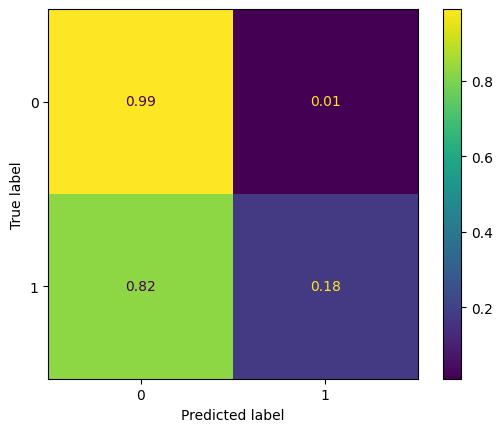

In [225]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, rf_grid.best_estimator_.predict(X_test), normalize= "true")

Segun el problema de negocio necesitamos un buen recall de la clase 1 y no lo estamos consiguiendo como vemos en la matriz de confusion. No podemos tener tantos falsos negativos en la clase 1. Para bajarlos hay que aplicar tecnicas como balanceo de clase, oversampling, undersamplig u otro modelo de ML mas complejo

 Procedemos a aplicar el balanceo de clase como parametro del RandomForest

In [220]:
rf_clf = rf_clf = RandomForestClassifier(max_depth = 2, 
                                         max_features = None, 
                                         max_samples = 0.3,
                                         min_samples_leaf = 20,
                                         n_estimators=  200,
                                         class_weight="balanced")
rf_clf.fit(X_train, y_train)
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2339
           1       0.40      0.17      0.24       168

    accuracy                           0.93      2507
   macro avg       0.67      0.58      0.60      2507
weighted avg       0.91      0.93      0.91      2507



Tampoco vemos mejora.

probamos ahora con el oversamplig

In [223]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

y_train_smote.value_counts()

Dlqin
0    9332
1    9332
Name: count, dtype: int64

In [224]:
rf_clf_smote = rf_clf_smote = RandomForestClassifier(max_depth = 2, 
                                         max_features = None, 
                                         max_samples = 0.3,
                                         min_samples_leaf = 20,
                                         n_estimators=  200)
rf_clf_smote.fit(X_train_smote, y_train_smote)
y_pred = rf_clf_smote.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.67      0.80      2339
           1       0.15      0.80      0.25       168

    accuracy                           0.68      2507
   macro avg       0.56      0.73      0.52      2507
weighted avg       0.92      0.68      0.76      2507



Al aplicar oversampling vemos como mejora sorprendentemente el recall de la clase 1.
Aunque sacrificando un poco el recall de la clase 0. Sin embargo cumplimos con la necesidad del negocio. Porque nos han pedido garantizar un buen recall de la clase 1. Es decir, necesitamos estar seguros de identificar correctamente las personas que van a delinquir en el pago para que la empresa no pierda dinero ofreciendole. Nos preocupa menos dejar pasar personas que pagarian y que cataloguemos como incumplidores. 